In [30]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns

from src.representation import get_representation, get_representation_from_series
from src.config import mem
from src.utils import get_fps_offset

# from rdkit import RDLogger
# RDLogger.DisableLog('rdApp.*')

dataset = pd.read_csv('../data/processed/dataset.csv', index_col=0)

In [32]:
# %time get_representation_from_series(train.smi[:100], n_jobs=1);
# %time get_representation_from_series(train.smi[:100], n_jobs=8);

In [33]:
df = mem.cache(get_representation_from_series, ignore=['n_jobs'])(dataset.smi, n_jobs=8)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, DTXSID2029290 to DTXSID9032581
Columns: 4389 entries, 0 to md_mZagreb2
dtypes: float64(4389)
memory usage: 48.9+ MB


In [34]:
df.shape

(1461, 4389)

In [35]:
# get fingerprints offset
FPS_OFFSET = get_fps_offset(df.columns)
FPS_OFFSET

2363

### drop na columns

In [36]:
mask = df.isna().sum() > 0
na_cols = df.columns[mask]
na_cols

Index(['rd_MaxAbsPartialCharge', 'rd_MaxPartialCharge',
       'rd_MinAbsPartialCharge', 'rd_MinPartialCharge', 'md_SpAbs_A',
       'md_SpMax_A', 'md_SpDiam_A', 'md_SpAD_A', 'md_SpMAD_A', 'md_LogEE_A',
       ...
       'md_MOMI-X', 'md_MOMI-Y', 'md_MOMI-Z', 'md_PBF', 'md_RotRatio',
       'md_TopoShapeIndex', 'md_PetitjeanIndex', 'md_Vabc', 'md_VAdjMat',
       'md_mZagreb1'],
      dtype='object', length=1109)

In [37]:
df.dropna(axis=1, inplace=True)

### drop all zero columns

In [38]:
mask = (df.iloc[:, FPS_OFFSET:] == 0).all()
zero_cols = df.iloc[:, FPS_OFFSET:].columns[mask]
zero_cols

Index(['rd_SMR_VSA8', 'rd_SlogP_VSA9', 'rd_fr_diazo', 'rd_fr_dihydropyridine',
       'rd_fr_isocyan', 'rd_fr_lactam', 'rd_fr_prisulfonamd', 'md_NsLi',
       'md_NssBe', 'md_NssssBe',
       ...
       'md_n5FaHRing', 'md_n6FaHRing', 'md_n7FaHRing', 'md_n8FaHRing',
       'md_n11FaHRing', 'md_n12FaHRing', 'md_n4FARing', 'md_n5FARing',
       'md_n4FAHRing', 'md_n5FAHRing'],
      dtype='object', length=130)

In [39]:
df.drop(columns=zero_cols, inplace=True)

# Correlations

In [40]:
corr = mem.cache(lambda x: x.corr())(df.iloc[:, FPS_OFFSET:])

In [41]:
# na correlated columns
mask = corr.iloc[0,:].isna()
na_corr_cols = corr.columns[mask]
na_corr_cols

Index([], dtype='object')

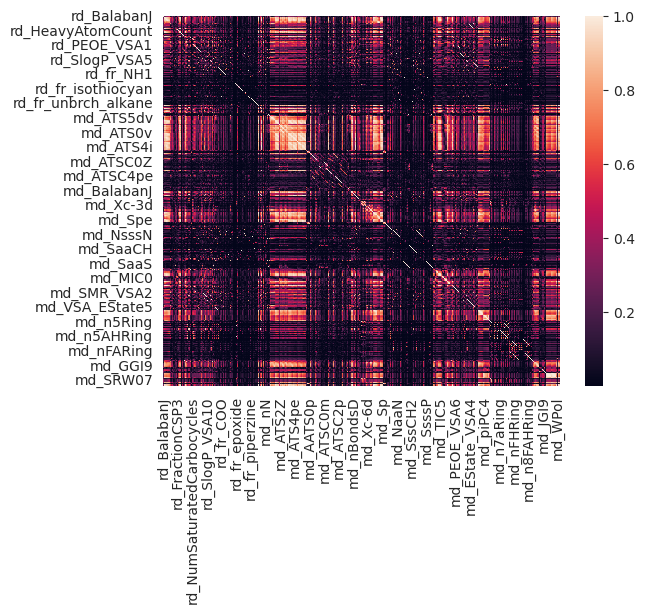

In [42]:
sns.heatmap(corr.abs());

In [43]:
train_ids = dataset.query("dataset == 'training'").index
test_ids = dataset.query("dataset != 'training'").index

In [44]:
len(train_ids), len(test_ids)

(961, 500)

In [45]:
train = df.loc[train_ids]
test = df.loc[test_ids]

In [46]:
descs_target = pd.concat([df.iloc[:, FPS_OFFSET:], dataset.loc[train_ids].target], axis=1)

corr = mem.cache(lambda x: x.corr())(descs_target)

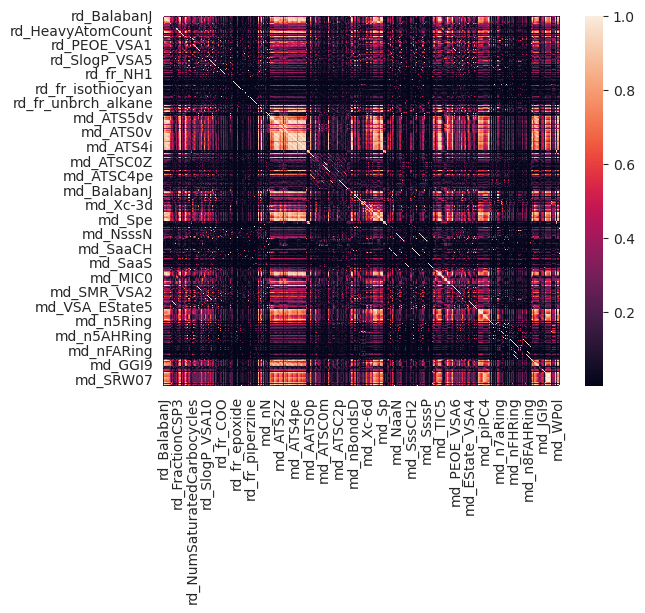

In [47]:
sns.heatmap(corr.abs());

In [48]:
from src.corr import noncorrelated_features

ids = noncorrelated_features(corr, threshold=0.95)

In [49]:
corr.columns[ids]

Index(['rd_BalabanJ', 'rd_Chi2v', 'rd_EState_VSA1', 'rd_EState_VSA11',
       'rd_EState_VSA3', 'rd_EState_VSA4', 'rd_EState_VSA5', 'rd_EState_VSA6',
       'rd_EState_VSA7', 'rd_EState_VSA8',
       ...
       'md_JGI8', 'md_JGI9', 'md_JGI10', 'md_JGT10', 'md_Radius', 'md_SRW07',
       'md_SRW10', 'md_TSRW10', 'md_WPath', 'md_Zagreb2'],
      dtype='object', length=427)

In [50]:
# md_cols = [c.replace('md_', '') for c in corr.columns[ids] if 'md_' in c]
# rd_cols = [c.replace('rd_', '') for c in corr.columns[ids] if 'rd_' in c]
md_cols = [c for c in corr.columns[ids] if 'md_' in c]
rd_cols = [c for c in corr.columns[ids] if 'rd_' in c]
rd_cols

['rd_BalabanJ',
 'rd_Chi2v',
 'rd_EState_VSA1',
 'rd_EState_VSA11',
 'rd_EState_VSA3',
 'rd_EState_VSA4',
 'rd_EState_VSA5',
 'rd_EState_VSA6',
 'rd_EState_VSA7',
 'rd_EState_VSA8',
 'rd_FpDensityMorgan1',
 'rd_FpDensityMorgan2',
 'rd_FpDensityMorgan3',
 'rd_FractionCSP3',
 'rd_HallKierAlpha',
 'rd_Ipc',
 'rd_Kappa2',
 'rd_Kappa3',
 'rd_MaxEStateIndex',
 'rd_MinAbsEStateIndex',
 'rd_MinEStateIndex',
 'rd_NumAliphaticCarbocycles',
 'rd_NumHDonors',
 'rd_NumRadicalElectrons',
 'rd_NumSaturatedCarbocycles',
 'rd_PEOE_VSA10',
 'rd_PEOE_VSA14',
 'rd_PEOE_VSA2',
 'rd_PEOE_VSA3',
 'rd_PEOE_VSA4',
 'rd_PEOE_VSA5',
 'rd_RingCount',
 'rd_SMR_VSA1',
 'rd_SMR_VSA10',
 'rd_SMR_VSA5',
 'rd_SMR_VSA6',
 'rd_SMR_VSA7',
 'rd_SMR_VSA9',
 'rd_SlogP_VSA1',
 'rd_SlogP_VSA10',
 'rd_SlogP_VSA12',
 'rd_SlogP_VSA5',
 'rd_SlogP_VSA7',
 'rd_VSA_EState1',
 'rd_VSA_EState2',
 'rd_VSA_EState3',
 'rd_VSA_EState4',
 'rd_VSA_EState5',
 'rd_VSA_EState9',
 'rd_fr_Al_COO',
 'rd_fr_Al_OH_noTert',
 'rd_fr_ArN',
 'rd_fr_Ar_C

In [51]:
md_cols

['md_nAcid',
 'md_nBase',
 'md_nSpiro',
 'md_nBridgehead',
 'md_nHetero',
 'md_nB',
 'md_nN',
 'md_nO',
 'md_nS',
 'md_nP',
 'md_ATS8dv',
 'md_ATS8Z',
 'md_ATS0m',
 'md_ATS3m',
 'md_ATS4m',
 'md_ATS5m',
 'md_ATS7m',
 'md_ATS0p',
 'md_ATS4p',
 'md_ATS8p',
 'md_ATS5i',
 'md_AATS0dv',
 'md_AATS0d',
 'md_AATS0m',
 'md_AATS0v',
 'md_AATS0pe',
 'md_AATS0i',
 'md_ATSC0dv',
 'md_ATSC1dv',
 'md_ATSC2dv',
 'md_ATSC3dv',
 'md_ATSC4dv',
 'md_ATSC5dv',
 'md_ATSC6dv',
 'md_ATSC7dv',
 'md_ATSC8dv',
 'md_ATSC1d',
 'md_ATSC2d',
 'md_ATSC3d',
 'md_ATSC4d',
 'md_ATSC5d',
 'md_ATSC6d',
 'md_ATSC7d',
 'md_ATSC8d',
 'md_ATSC3Z',
 'md_ATSC4Z',
 'md_ATSC5Z',
 'md_ATSC6Z',
 'md_ATSC7Z',
 'md_ATSC0m',
 'md_ATSC1m',
 'md_ATSC2m',
 'md_ATSC8m',
 'md_ATSC1v',
 'md_ATSC2v',
 'md_ATSC3v',
 'md_ATSC4v',
 'md_ATSC5v',
 'md_ATSC6v',
 'md_ATSC7v',
 'md_ATSC8v',
 'md_ATSC0pe',
 'md_ATSC1pe',
 'md_ATSC2pe',
 'md_ATSC3pe',
 'md_ATSC4pe',
 'md_ATSC5pe',
 'md_ATSC6pe',
 'md_ATSC7pe',
 'md_ATSC8pe',
 'md_ATSC0p',
 'md_ATSC1p'

In [52]:
fps_cols = list(range(FPS_OFFSET))

In [53]:
df.loc[train_ids, fps_cols + rd_cols + md_cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, DTXSID9048512 to DTXSID3040352
Columns: 2790 entries, 0 to md_Zagreb2
dtypes: float64(2790)
memory usage: 20.5+ MB


In [54]:
corr.iloc[ids, -1].abs().sort_values(ascending=False)

md_C2SP2           0.412488
md_NaasC           0.391997
md_n6aRing         0.384880
md_piPC7           0.379015
md_MIC5            0.364103
                     ...   
md_C1SP1           0.000440
md_Xch-7d          0.000103
rd_fr_tetrazole         NaN
md_SddC                 NaN
md_SdNH                 NaN
Name: target, Length: 427, dtype: float64

In [55]:
X_train = df.loc[train_ids, fps_cols + rd_cols + md_cols]
X_train.shape

(961, 2790)

In [56]:
X_test = df.loc[test_ids, fps_cols + rd_cols + md_cols]
X_test.shape

(500, 2790)

In [57]:
y_train = dataset.loc[train_ids, 'target']
y_test = dataset.loc[test_ids, 'target']

In [58]:
X_train.to_csv('../data/processed/X_train.csv')
y_train.to_csv('../data/processed/y_train.csv')

X_test.to_csv('../data/processed/X_test.csv')
y_test.to_csv('../data/processed/y_test.csv')